In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import scipy.optimize as spo
import pandas as pd

In [6]:
### Markowitz portfolio optimization
class Markowitz:
    """
    Returns the optimal portfolio weights and the corresponding Sharpe ratio.
    Reference: https://ocw.mit.edu/courses/18-s096-topics-in-mathematics-with-applications-in-finance-fall-2013/resources/mit18_s096f13_lecnote14/
    Returns: Must have at least 2 assets each with at least 2 returns listed.
    Return period: >= 2, 12 for monthly, 52 for weekly, 252 for yearly.
    """
    def __init__(self, tickers: list, returns: list, return_period: int):
        self.TICKERS = tickers
        self.UNIFORM_WEIGHTS = np.ones(len(returns)) / len(returns)
        self.RETURNS = np.asarray(returns).copy()
        self.FREQUENCY = return_period
        self.COV = np.cov(self.RETURNS)
    
    def _neg_sharpe_ratio(self, weights: list, risk_free_rate: float = 0.0):
        """
        Returns the Sharpe ratio of the portfolio.
        """
        expected_return = np.sum(np.dot(weights, self.RETURNS))*self.FREQUENCY
        standard_deviation = np.sqrt(np.dot(weights, np.dot(self.COV, weights)))*np.sqrt(self.FREQUENCY)
        return (expected_return - risk_free_rate) / standard_deviation
    
    def _mean(self, weights: list):
        """
        Returns the expected return of the portfolio.
        """
        return np.sum(np.dot(weights, self.RETURNS))*self.FREQUENCY
    
    def _variance(self, weights: list):
        """
        Returns the variance of the portfolio.
        """
        return np.dot(weights.T, np.dot(self.COV, weights))

    def _sd(self, weights: list):
        """
        Returns the standard deviation of the portfolio.
        """
        return np.sqrt(np.dot(weights, np.dot(self.COV, weights)))*np.sqrt(self.FREQUENCY)

    # Return Maximization
    def max_sharpe(self, risk_free_rate: float = 0.0, weight_constraint: tuple = (0,1)):
        """
        Returns the optimal portfolio weights and the corresponding Sharpe ratio.
        Use the negative Sharpe ratio as the objective function to be minimized.
        """
        init_weights = self.UNIFORM_WEIGHTS
        method='SLSQP'
        bounds=[weight_constraint] * len(self.RETURNS)
        constraints={'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        args = (risk_free_rate)
        # minimize the negative Sharpe ratio
        result = spo.minimize(self._neg_sharpe_ratio, init_weights, method=method, bounds=bounds, constraints=constraints, args=args)
        # status, weights, Sharpe ratio, mean, variance, stdev
        return result.success, result.x, -result.fun, self._mean(result.x), self._variance(result.x), self._sd(result.x)
        
    # Risk Minimization
    def min_variance(self, weight_constraint: tuple = (0,1), risk_free_rate: float = 0.0):
        """
        Returns the optimal portfolio weights and the corresponding variance.
        Use the variance as the objective function to be minimized.
        """
        # minimize the variance
        init_weights = self.UNIFORM_WEIGHTS
        method='SLSQP'
        bounds=[weight_constraint] * len(self.RETURNS)
        # , 'type': 'eq', 'fun': lambda x: np.dot(x, self.RETURNS) - target_return
        constraints={'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        result = spo.minimize(self._variance, init_weights, method=method, bounds=bounds, constraints=constraints)
        # status, weights, Sharpe, mean:return, variance, stdev
        return result.success, result.x, -self._neg_sharpe_ratio(result.x, risk_free_rate), self._mean(result.x), result.fun, self._sd(result.x)

    # Optimize a portfolio given a target return or a target variance
    def optimize(self, target_return: float = None, target_variance: float = None, risk_free_rate: float = 0.0, weight_constraint: tuple = (0,1)):
        """
        Returns the optimal portfolio weights and the corresponding Sharpe ratio.
        Use the negative Sharpe ratio as the objective function to be minimized.
        """
        # minimize the negative Sharpe ratio
        init_weights = self.UNIFORM_WEIGHTS
        method='SLSQP'
        bounds=[weight_constraint] * len(self.RETURNS)
        if target_return is not None:
            constraints={'type': 'eq', 'fun': lambda x: np.dot(x, self.RETURNS) - target_return, 'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
            args = (risk_free_rate)
            result = spo.minimize(self._neg_sharpe_ratio, init_weights, method=method, bounds=bounds, constraints=constraints, args=args)
        elif target_variance is not None:
            constraints={'type': 'eq', 'fun': lambda x: np.dot(x.T, np.dot(self.COV, x)) - target_variance, 'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
            result = spo.minimize(self._variance, init_weights, method=method, bounds=bounds, constraints=constraints)
        else:
            raise ValueError("Must provide either a target return or a target variance, but not both.")
        
        # status, weights, Sharpe ratio, mean, variance
        return result.success, result.x, -self._neg_sharpe_ratio(result.x, risk_free_rate), self._mean(result.x), self._variance(result.x), self._sd(result.x)
    
    # Create a summary table of optimal portfolios, weights, Sharpe ratios, means, and variances
    def summary(self, risk_free_rate: float = 0.0, weight_constraint: tuple = (0,1)):
        """
        Returns a summary table of optimal portfolios, weights, Sharpe ratios, means, and variances.
        """
        # opt portfolios
        min_variance = self.min_variance(weight_constraint, risk_free_rate)
        max_sharpe = self.max_sharpe(risk_free_rate, weight_constraint)
        # summary table
        max_sharpe_df = pd.DataFrame(columns=['Tickers', 'Weights'])
        min_var_df = pd.DataFrame(columns=['Tickers', 'Weights'])
        summary_df = pd.DataFrame(columns=['Portfolio', 'Weights', 'Sharpe Ratio', 'Return', 'Variance', 'Standard Deviation'])
        # max sharpe
        max_sharpe_df['Tickers'] = self.TICKERS
        max_sharpe_df['Weights'] = max_sharpe[1].round(4)
        max_sharpe_df = max_sharpe_df.set_index('Tickers')
        print("Max Sharpe:")
        print(max_sharpe_df)
        # min variance
        min_var_df['Tickers'] = self.TICKERS
        min_var_df['Weights'] = min_variance[1].round(4)
        min_var_df = min_var_df.set_index('Tickers')
        print("Min Variance:")
        print(min_var_df)
        # summary
        summary_df['Portfolio'] = ['Max Sharpe', 'Min Variance']
        summary_df['Weights'] = [dict(zip(self.TICKERS, max_sharpe[1].round(4))),dict(zip(self.TICKERS, min_variance[1].round(4)))]
        summary_df['Sharpe Ratio'] = [max_sharpe[2].round(4), min_variance[2].round(4)]
        summary_df['Return'] = [max_sharpe[3].round(4), min_variance[3].round(4)]
        summary_df['Variance'] = [max_sharpe[4].round(4), min_variance[4].round(4)]
        summary_df['Standard Deviation'] = [max_sharpe[5].round(4), min_variance[5].round(4)]
        summary_df = summary_df.set_index('Portfolio')
        print("Summary:")
        print(summary_df)
        return summary_df, max_sharpe_df, min_var_df



    # Plot the efficient frontier
    def efficient_frontier(self, risk_free_rate: float = 0.0, weight_constraint: tuple = (0,1)):
        """
        Plots the efficient frontier.
        Iterates through optimal portfolios from min_variance to max_sharpe.
        """
        returns = []
        stds = []
        target_returns = np.linspace(self._mean(self.min_variance(weight_constraint, risk_free_rate)[1]), self._mean(self.max_sharpe(risk_free_rate, weight_constraint)[1]), 100)
        for target_return in target_returns:
            opt = self.optimize(target_return=target_return, risk_free_rate=risk_free_rate, weight_constraint=weight_constraint)
            returns.append(opt[3])
            stds.append(opt[5])
        plt.figure(figsize=(12,8))
        plt.scatter(stds, returns, c=(np.array(returns)-risk_free_rate)/np.array(stds), marker='o')
        plt.grid(True)
        plt.xlabel('Expected Volatility')
        plt.ylabel('Expected Return')
        plt.colorbar(label='Sharpe Ratio')
        plt.title('Efficient Frontier')
        plt.show()



        


(True, array([1.00000000e+00, 2.73409073e-12, 1.68314251e-11, 0.00000000e+00,
       3.69343445e-12]), -6.000000000139668, 0.599999999996972, 0.004999999999716754, 0.09999999999716754)
(True, array([0.0297619 , 0.20436508, 0.33531746, 0.20436508, 0.22619048]), -1241031397.0972095, 0.48666666634113354, 7.688961175772845e-20, 3.921469412292501e-10)
Max Sharpe:
         Weights
Tickers         
A            1.0
B            0.0
C            0.0
D            0.0
E            0.0
Min Variance:
         Weights
Tickers         
A         0.0298
B         0.2044
C         0.3353
D         0.2044
E         0.2262
Summary:
                                                        Weights  Sharpe Ratio  \
Portfolio                                                                       
Max Sharpe    {'A': 1.0, 'B': 0.0, 'C': 0.0, 'D': 0.0, 'E': ... -6.000000e+00   
Min Variance  {'A': 0.0298, 'B': 0.2044, 'C': 0.3353, 'D': 0... -1.241031e+09   

              Return  Variance  Standard Deviation  


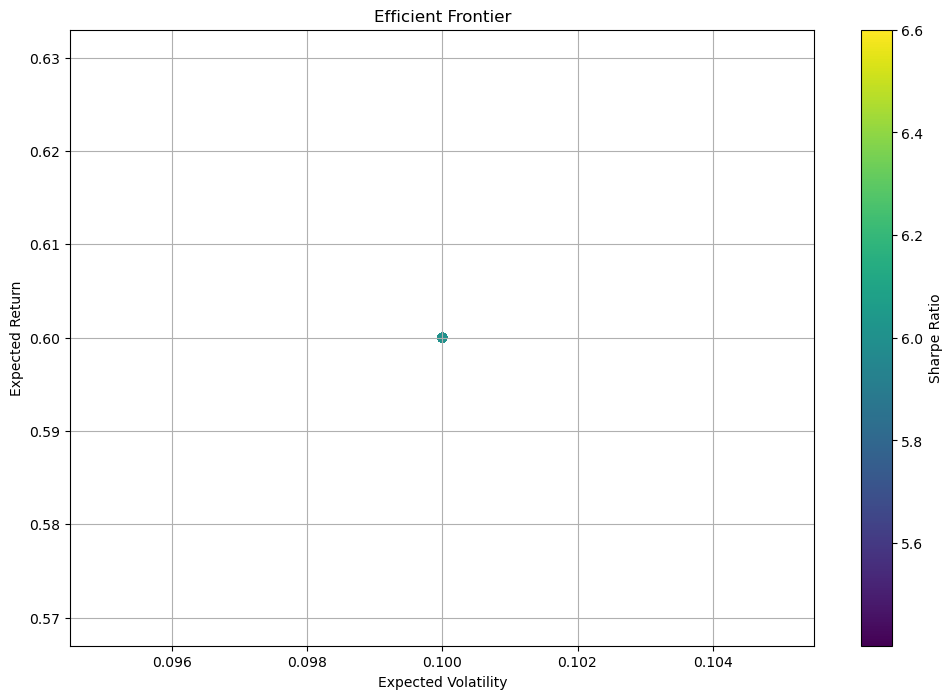

In [10]:
# test max sharpe
tickers = ['A', 'B', 'C', 'D', 'E']
returns =[[0.1, 0.2], [0.15 ,0.17], [0.12,0.08], [0.09,0.11], [0.13,0.14]]
markowitz= Markowitz(tickers, returns, 2)
res1 = markowitz.max_sharpe()
# test min variance
res2 = markowitz.min_variance()
print(res1)
print(res2)

# test summary
summary_df, max_sharpe_df, min_var_df = markowitz.summary()

# test efficient frontier
markowitz.efficient_frontier()

In [126]:
x =[[0, 0.2], [0 ,0.17], [0,0.08], [0,0.11], [0,0.14]]
w = [1/len(x)]*len(x)
cov = np.cov(x)
print("cov", cov)
print("w", w)

cov [[0.02    0.017   0.008   0.011   0.014  ]
 [0.017   0.01445 0.0068  0.00935 0.0119 ]
 [0.008   0.0068  0.0032  0.0044  0.0056 ]
 [0.011   0.00935 0.0044  0.00605 0.0077 ]
 [0.014   0.0119  0.0056  0.0077  0.0098 ]]
w [0.2, 0.2, 0.2, 0.2, 0.2]
